 ## Bayesian Optimization 1-Dimensional function

 We will use Bayesian Optimization to find the best number of estimators for a Gradient Boosting Machine. That is , we will optimize the number of trees for our ensemble

 Beacause we are optimizing only 1 hyperparameter, the number of trees

### 1.1 
Scikit-optimize will always minimize the objetive function, so if we want to maximize a function, for example the roc-auc, we need to negate the metric. Thus, instead of maximizing the roc-auc, we minimize the roc-auc

In [2]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

In [3]:
!pip install scikit-optimize

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV,
)

from skopt import gp_minimize

from skopt.plots import plot_convergence, plot_gaussian_process
from skopt.utils import use_named_args

In [5]:
#Load dataset 
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
#The target :
#Percentage of beningn (0) and malign tumors(1)


In [7]:
y.value_counts() / len(y)

1    0.627417
0    0.372583
Name: count, dtype: float64

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

X_train.shape, X_test.shape

((455, 30), (114, 30))

### Determine the hyperparameter response function

We are agoing to map the hperparameter response function for 1 parameter, the number of estimators. This way, we have a 1-dimensional function that we can use to relate to the theoretical videos we discussed throughout this section

In [9]:
#Set up the model
gbm = GradientBoostingClassifier(random_state = 42)

#determine the hyperparameter space
 
param_grid = {
    'n_estimators': [10, 20, 50, 100, 120, 150, 200, 250, 300],
}

#Grid search
search = GridSearchCV(gbm, param_grid, scoring='accuracy', cv=5, refit = False)

#Find the best hyperparame
# 
# 
# ters

search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'n_estimators': [10, 20, 50, 100, 120, 150, 200, 250,
                                          300]},
             refit=False, scoring='accuracy')

In [10]:
results = pd.DataFrame(search.cv_results_)
results.sort_values(by = 'param_n_estimators', inplace = True, ascending = False)

results[['param_n_estimators', 'mean_test_score', 'std_test_score']]

,param_n_estimators,mean_test_score,std_test_score
8,300,0.964835,0.023466
7,250,0.964835,0.024474
6,200,0.967033,0.025059
5,150,0.969231,0.021308
4,120,0.967033,0.020850
3,100,0.964835,0.017582
2,50,0.956044,0.020850
1,20,0.949451,0.017855
0,10,0.940659,0.014906


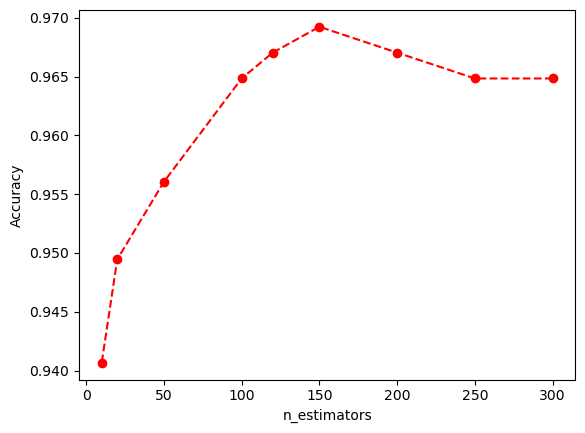

In [11]:
#Plot f(x) - 1-D hyperparameter respnse function

plt.plot(results['param_n_estimators'], results['mean_test_score'], "ro--")
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.show()

### Define the hyperparameter Space

In [12]:
from skopt.space import Integer

#With Integer, we create a space of integers, sampled uniformly
#between the minimus and maximum indcated values

Integer(10,300, name = 'n_estimators')

Integer(low=10, high=300, prior='uniform', transform='identity')

In [13]:
#Specify the hyperparameter space
param_grid = [Integer(10,300, name= "n_estimators")]

#Scikit-optimize minimizes the objective function
type(param_grid)

list

In [14]:
param_grid

[Integer(low=10, high=300, prior='uniform', transform='identity')]

### Define the objetive function
This is hyperparameter space, the function we want to minimize

In [15]:
# We desiugn a function to maximize the accuracy of the model
# with cross-validation

@use_named_args(param_grid)
def objective(**params):

    #Model with new parameters
    gbm.set_params(**params)

    #optimization function (cross-validation)
    value = np.mean(cross_val_score(gbm, X_train, y_train, cv=5, n_jobs = -4, scoring = 'accuracy'))
    return -value

## Basyesian Optimization

We are now ready for sequential model-based optimization. Here we use Gaussian process-base optimization

In [17]:
#gp_minimize performs by default gp optimization
gp = gp_minimize(
    objective, # The objetive 
    param_grid, # The hyperparemeter space
    n_initial_points= 2, # The number of points to evaluate f(x) to start of
    acq_func='EI', # Expected Improvement
    n_calls= 20, # The number of subsequent evaluations of f(x)
    random_state= 42,
)

c:\Users\vish8\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [300] before, using random point [198]
  warnings.warn(
c:\Users\vish8\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [300] before, using random point [234]
  warnings.warn(
c:\Users\vish8\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [300] before, using random point [159]
  warnings.warn(
c:\Users\vish8\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [300] before, using random point [147]
  warnings.warn(
c:\Users\vish8\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [300] before, using random point [250]
  warnings.warn(
c:\Users\vish8\anaconda3\Lib\site-packages\skopt\optimizer\o

In [18]:
"Best score=%.4f" % gp.fun

'Best score=-0.9714'

In [20]:
print("""Best parameters:- n_estimators=%d""" % (gp.x[0]))

Best parameters:- n_estimators=159


## Evaluate convergence of the search

This plot let's us visualize if the Bayesian Optimization has found the minimum of the response function


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

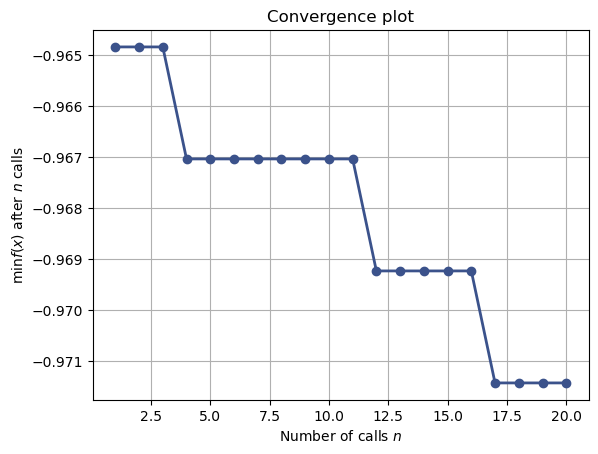

In [22]:
plot_convergence(gp)

### Plot Bayesian Optimization Search


TypeError: 'bool' object is not callable

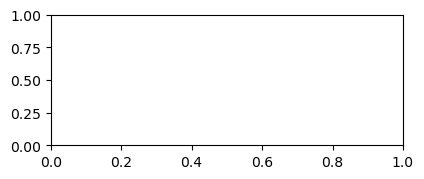

In [23]:
end = 10

for n_iter in range(end):

    #figure size
    plt.figure(figsize=(10, 20))

    #2 plots next to each other, left plot 
    plt.subplot(end, 2, 2 * n_iter + 1)

    #plot gaussian process search
    plot_gaussian_process(gp, n_calls = n_iter, objective = False, show_legend = False)

    #Plot true hyperparameter
    ax.scatter(results['param_n_estimators'], results['mean_test_score'], color = 'red', s = 100, zorder = 10)
    ax.set_title(f'Iteration {n_iter}')
    ax.set_xlabel("")
    ax.set_ylabel("")

    #plot acquisition function
    plt.subplot(end, 2, 2 * n_iter + 2)

    ax = plot_gaussian_process(gp, n_calls = n_iter, show_legend = False)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.show()
